<a href="https://colab.research.google.com/github/cesar1091/Mini-Project---I-m-Something-of-a-Painter-Myself/blob/dev/GAN_colab_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/gan-getting-started.zip" "/content/"

In [4]:
from zipfile import ZipFile

with ZipFile('gan-getting-started.zip', 'r') as zip_ref:
    zip_ref.extractall('gan_data')  # Extrae todo en una carpeta 'gan_data'

print("¡Archivo descomprimido en la carpeta 'gan_data'!")

¡Archivo descomprimido en la carpeta 'gan_data'!


In [5]:
import keras
import tensorflow as tf
from keras import layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np

# Prepare data

We'll use images from two directories: `monet` and `photo`. The `monet` directory contains paintings by Claude Monet, while the `photo` directory contains photographs of the same scenes. The goal is to train a neural network to transform a photograph into a Monet-style painting.


In [6]:
BATCH_SIZE = 8
EPOCHS = 10

Shape of image: (256, 256, 3)


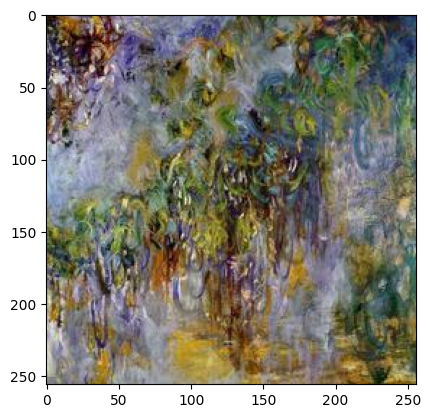

In [7]:
from matplotlib.image import imread
image = imread("gan_data/monet_jpg/0a5075d42a.jpg")
print("Shape of image:", image.shape)
plt.imshow(image)
plt.show()

In [8]:
dataset_monet = keras.utils.image_dataset_from_directory("gan_data/monet_jpg",label_mode=None, image_size=(256, 256), batch_size=BATCH_SIZE)

Found 300 files.


Shape of image: (256, 256, 3)


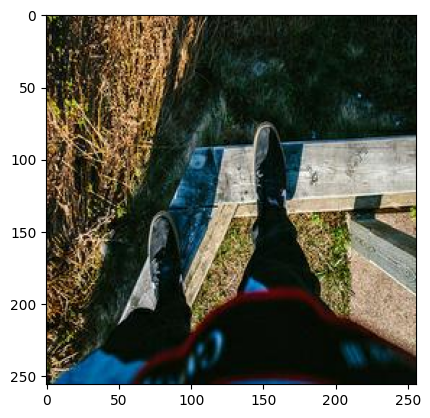

In [9]:
from matplotlib.image import imread
image = imread("gan_data/photo_jpg/00c6a0ad1e.jpg")
print("Shape of image:", image.shape)
plt.imshow(image)
plt.show()

In [10]:
dataset_photo = keras.utils.image_dataset_from_directory("gan_data/photo_jpg",label_mode=None, image_size=(256, 256), batch_size=BATCH_SIZE)

Found 7038 files.


In [11]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1.0
    return image

dataset_monet = dataset_monet.map(preprocess)
dataset_photo = dataset_photo.map(preprocess)

# Create the discriminator

The discriminator is a convolutional neural network (CNN) that classifies images as real or fake. It takes an image as input and outputs a probability that the image is real (from the dataset) or fake (generated by the generator). The discriminator is trained to maximize the probability of correctly classifying real and fake images.

In [35]:
discriminator = models.Sequential([
    layers.Input(shape=(256, 256, 3)),
    layers.Conv2D(256, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(negative_slope=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(negative_slope=0.2),
    layers.Conv2D(64, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(negative_slope=0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
],
name="discriminator")
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 256)       │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 128, 128, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │          65,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 733,633 (2.80 MB)

 Trainable params: 733,633 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

# Create the generator
The generator is a deep convolutional neural network (DCGAN) that takes a random noise vector as input and generates an image. The generator is trained to minimize the probability of the discriminator correctly classifying the generated image as fake. The generator and discriminator are trained together in an adversarial manner, where the generator tries to fool the discriminator while the discriminator tries to correctly classify real and fake images.

In [13]:
latent_dim = 64
generator = models.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(32*32*64),
    layers.Reshape((32, 32, 64)),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(3, kernel_size=5, padding='same', activation='sigmoid')
],
name="generator")
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 131072)              │      16,908,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 64, 64, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 128, 128, 256)       │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128, 128, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 256, 256, 512)       │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 256, 256, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 3)         │          38,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,831,171 (75.65 MB)

 Trainable params: 19,831,171 (75.65 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Optimizers
generator_optimizer = optimizers.Adam(learning_rate=0.002, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(learning_rate=0.002, beta_1=0.5)

# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
@tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [17]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
        plt.axis('off')
    plt.savefig(f"images/image_at_epoch_{epoch:04d}.png")
    plt.close()

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}')

        if (epoch + 1) % 10 == 0:
            latent_dim = 128
            seed = tf.random.normal([16, latent_dim])
            generate_and_save_images(generator, epoch + 1, seed)

    generator.save(f"models/generator.keras")
    discriminator.save(f"models/discriminator.keras")

In [18]:
import os

os.makedirs("models",exist_ok=True)
os.makedirs("images",exist_ok=True)

In [19]:
# Entrenar el modelo
train(dataset_photo, EPOCHS)

Epoch 1, Gen Loss: 8983.734375, Disc Loss: 0.0
Epoch 2, Gen Loss: 8552.3583984375, Disc Loss: 0.0
Epoch 3, Gen Loss: 17220.515625, Disc Loss: 0.0
Epoch 4, Gen Loss: 17239.7890625, Disc Loss: 0.0
Epoch 5, Gen Loss: 17297.720703125, Disc Loss: 0.0
Epoch 6, Gen Loss: 17161.046875, Disc Loss: 0.0
Epoch 7, Gen Loss: 17315.20703125, Disc Loss: 0.0
Epoch 8, Gen Loss: 17242.046875, Disc Loss: 0.0
Epoch 9, Gen Loss: 17253.51171875, Disc Loss: 0.0
Epoch 10, Gen Loss: 17267.814453125, Disc Loss: 0.0


In [20]:
generator.save(f"models/generator.keras")
discriminator.save(f"models/discriminator.keras")

In [21]:
# Submission

import os
from tqdm import tqdm
import cv2

# Configuración
num_images = 7000
#latent_dim = 128

with ZipFile('images.zip', 'w') as zipf:
    for i in tqdm(range(num_images)):
        # 1. Generar imagen
        noise = tf.random.normal([1, latent_dim])
        image = generator(noise)[0].numpy()

        # 2. Convertir a formato JPG en memoria
        image = (image * 127.5 + 127.5).astype(np.uint8)
        is_success, buffer = cv2.imencode(".jpg", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

        # 3. Escribir directamente al ZIP
        zipf.writestr(f"image_{i}.jpg", buffer)

100%|██████████| 7000/7000 [04:55<00:00, 23.72it/s]


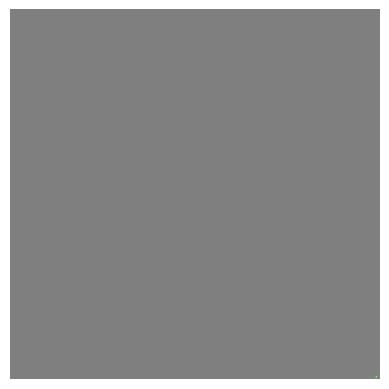

In [33]:
noise = tf.random.normal([1, latent_dim])
image = generator(noise)[0].numpy()
image = (image * 127.5 + 127.5).astype(np.uint8)
plt.imshow(image)
plt.axis('off')
plt.show()

array([[[127, 127, 127],
        [127, 127, 127],
        [127, 127, 127],
        ...,
        [127, 127, 127],
        [127, 127, 127],
        [127, 127, 127]],

       [[127, 127, 127],
        [127, 127, 127],
        [127, 127, 127],
        ...,
        [127, 127, 127],
        [127, 127, 127],
        [127, 127, 127]],

       [[127, 127, 127],
        [127, 127, 127],
        [127, 127, 127],
        ...,
        [127, 127, 127],
        [127, 127, 127],
        [127, 127, 127]],

       ...,

       [[127, 127, 127],
        [127, 127, 127],
        [127, 127, 127],
        ...,
        [127, 127, 127],
        [127, 127, 127],
        [127, 127, 127]],

       [[127, 127, 127],
        [127, 127, 127],
        [127, 127, 127],
        ...,
        [127, 255, 127],
        [127, 127, 127],
        [127, 127, 127]],

       [[127, 127, 127],
        [127, 127, 127],
        [127, 127, 127],
        ...,
        [127, 127, 127],
        [127, 127, 127],
        [127, 127, 127]]], dtype=uint8)
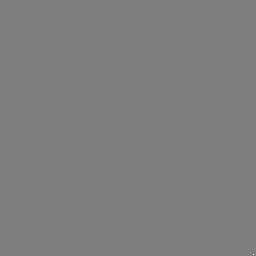

In [34]:
image